## 1. Import Packages

Below, we import both standard packages, and functions from the accompanying .py files

In [78]:
#Import standard packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
from scipy import stats
import pickle

#Import function to get the covariate matrix that includes spike history from previous bins
from preprocessing_funcs import get_spikes_with_history

#Import metrics
from metrics import get_R2
from metrics import get_rho

#Import decoder functions
from decoders import WienerCascadeDecoder
from decoders import WienerFilterDecoder
from decoders import DenseNNDecoder
from decoders import SimpleRNNDecoder
from decoders import GRUDecoder
from decoders import LSTMDecoder
from decoders import XGBoostDecoder

## 2. Load Data

The data that we load is in the format described below. We have another example script, "neural_preprocessing.py" that may be helpful towards putting the data in this format.

Neural data should be a matrix of size "number of time bins" x "number of neurons", where each entry is the firing rate of a given neuron in a given time bin

The output you are decoding should be a matrix of size "number of time bins" x "number of features you are decoding"

In [79]:
# folder='/Users/jig289/Dropbox/MATLAB/Projects/In_Progress/BMI/Processed_Data/'
# folder='/Users/jig289/Dropbox/Grad_School/Research/Projects/In_Progress/Decoding/DataFiles/'
folder='/home/jglaser2/Data/DecData/'

with open(folder+'hc_test_data.pickle','rb') as f:
    neural_data,pos_binned=pickle.load(f)

## 3. Preprocess Data

### 3A. User Inputs
The user can define what time period to use spikes from (with respect to the output).

In [80]:
bins_before=4 #How many bins of neural data prior to the output are used for decoding
bins_current=1 #Whether to use concurrent time bin of neural data
bins_after=5 #How many bins of neural data after (and including) the output are used for decoding

### 3B. Format Covariates

#### Format Input Covariates

In [81]:
#Remove neurons with too few spikes
nd_sum=np.nansum(neural_data,axis=0)
# rmv_nrn=np.where(nd_sum<200) #For WF and WC
rmv_nrn=np.where(nd_sum<100)
neural_data=np.delete(neural_data,rmv_nrn,1)

# Format for recurrent neural networks (SimpleRNN, GRU, LSTM)
# Function to get the covariate matrix that includes spike history from previous bins
X=get_spikes_with_history(neural_data,bins_before,bins_after,bins_current)

# Format for Wiener Filter, Wiener Cascade, XGBoost, and Dense Neural Network
#Put in "flat" format, so each "neuron / time" is a single feature
X_flat=X.reshape(X.shape[0],(X.shape[1]*X.shape[2]))

#### Format Output Covariates

In [82]:
#Set decoding output
y=pos_binned

### 3C. Process Covariates
We normalize (z_score) the inputs and zero-center the outputs.

In [83]:
#Z-scoring function that works with Nans:
def zscore_nan(X,axis):
    X_zscore=(X - np.nanmean(X,axis=axis)) / np.nanstd(X,axis=axis)
    return X_zscore

In [84]:
#Normalize inputs
X=zscore_nan(X,axis=0)
X_flat=zscore_nan(X_flat,axis=0)

#Zero-center outputs
y_mean=np.nanmean(y,axis=0)
y=y-y_mean

In [85]:
#Remove time bins with no output (y value)
rmv_time=np.where(np.isnan(y[:,0]) | np.isnan(y[:,1]))
X=np.delete(X,rmv_time,0)
X_flat=np.delete(X_flat,rmv_time,0)
y=np.delete(y,rmv_time,0)

### 3D. Split into training/testing sets

#### User Options

In [86]:
#Set what part of data should be part of the training/testing/validation sets
training_range=[0, 0.4]
testing_range=[0.4, .8]

#### Split Data

In [87]:
num_examples=X.shape[0]

#Note that each range has a buffer of"bins_before" bins at the beginning, and "bins_after" bins at the end
#This makes it so that the different sets don't include overlapping neural data
training_set=np.arange(np.int(np.round(training_range[0]*num_examples))+bins_before,np.int(np.round(training_range[1]*num_examples))-bins_after)
testing_set=np.arange(np.int(np.round(testing_range[0]*num_examples))+bins_before,np.int(np.round(testing_range[1]*num_examples))-bins_after)

#Get training data
X_train=X[training_set,:,:]
X_flat_train=X_flat[training_set,:]
y_train=y[training_set,:]

#Get testing data
X_test=X[testing_set,:,:]
X_flat_test=X_flat[testing_set,:]
y_test=y[testing_set,:]

## 4. Train Decoders

### 4A. Wiener Filter (Linear Regression)

In [88]:
#Declare model
model_wf=WienerFilterDecoder()
#Fit model
model_wf.fit(X_flat_train,y_train)

### 4B. Wiener Cascade (Linear Nonlinear Model)

In [89]:
#Declare model
model_wc=WienerCascadeDecoder(degree=2)
#Fit model
model_wc.fit(X_flat_train,y_train)

### 4C. XGBoost (Extreme Gradient Boosting)

In [103]:
#Declare model
model_xgb=XGBoostDecoder(max_depth=3,num_round=200)
#Fit model
model_xgb.fit(X_flat_train, y_train)

### 4D. Dense Neural Network

In [91]:
#Declare model
model_dnn=DenseNNDecoder(units=[600,600],dropout=.25,num_epochs=30)
#Fit model
model_dnn.fit(X_flat_train,y_train)

### 4E. Simple RNN

In [92]:
#Declare model
model_rnn=SimpleRNNDecoder(units=400,dropout=0,num_epochs=15)
#Fit model
model_rnn.fit(X_train,y_train)

### 4F. GRU (Gated Recurrent Unit)

In [93]:
#Declare model
model_gru=GRUDecoder(units=400,dropout=.25,num_epochs=10)
#Fit model
model_gru.fit(X_train,y_train)

### 4G. LSTM (Long Short Term Memory)

In [94]:
#Declare model
model_lstm=LSTMDecoder(units=600,dropout=.25,num_epochs=20)
#Fit model
model_lstm.fit(X_train,y_train)

## 5. Save Model Fits

In [48]:
# with open('s1_models.pickle','wb') as f:
#     pickle.dump([model_wf,model_wc,model_xgb,model_dnn,model_rnn,model_gru,model_lstm],f)

## 6. Get Fits on Test Data

In [104]:
num_splits=10
num_bs=200
num_test_examples=y_test.shape[0]
num_examples_per_split=np.round(np.divide(num_test_examples,num_splits))

#Initialize
mean_R2_wf=np.empty(num_bs)
mean_R2_wc=np.empty(num_bs)
mean_R2_xgb=np.empty(num_bs)
mean_R2_dnn=np.empty(num_bs)
mean_R2_rnn=np.empty(num_bs)
mean_R2_gru=np.empty(num_bs)
mean_R2_lstm=np.empty(num_bs)

y_preds_wf=np.empty([num_splits,num_examples_per_split,y_test.shape[1]])
y_preds_wc=np.empty([num_splits,num_examples_per_split,y_test.shape[1]])
y_preds_xgb=np.empty([num_splits,num_examples_per_split,y_test.shape[1]])
y_preds_dnn=np.empty([num_splits,num_examples_per_split,y_test.shape[1]])
y_preds_rnn=np.empty([num_splits,num_examples_per_split,y_test.shape[1]])
y_preds_gru=np.empty([num_splits,num_examples_per_split,y_test.shape[1]])
y_preds_lstm=np.empty([num_splits,num_examples_per_split,y_test.shape[1]])


for i in range(num_splits):
    idx=np.arange(num_examples_per_split*i,num_examples_per_split*(i+1))
    X_test_temp=X_test[idx,:,:]
    X_flat_test_temp=X_flat_test[idx,:]
    
    #Wiener Filter
    y_preds_wf[i,:,:]=model_wf.predict(X_flat_test_temp)
    
    #Wiener Cascade
    y_preds_wc[i,:,:]=model_wc.predict(X_flat_test_temp)
    
    #XGBoost
    y_preds_xgb[i,:,:]=model_xgb.predict(X_flat_test_temp)
    
    #DNN
    y_preds_dnn[i,:,:]=model_dnn.predict(X_flat_test_temp)
    
    #RNN
    y_preds_rnn[i,:,:]=model_rnn.predict(X_test_temp)
    
    #GRU
    y_preds_gru[i,:,:]=model_gru.predict(X_test_temp)
    
    #LSTM
    y_preds_lstm[i,:,:]=model_lstm.predict(X_test_temp)

    
    
    
y_test_bs=np.empty([num_splits,num_examples_per_split,y_test.shape[1]])
for i in range(num_splits):
    idx=np.arange(num_examples_per_split*i,num_examples_per_split*(i+1))
    y_test_bs[i,:,:]=y_test[idx,:]    
    
for i in range(num_bs): 
    
    random_idxs=np.floor(num_splits*np.random.rand(10)).astype(int)
    y_test_temp=np.reshape(y_test_bs[random_idxs,:,:],[y_test_bs.shape[0]*y_test_bs.shape[1],y_test_bs.shape[2]])    
    y_predicted_wf=np.reshape(y_preds_wf[random_idxs,:,:],[y_test_bs.shape[0]*y_test_bs.shape[1],y_test_bs.shape[2]])    
    y_predicted_wc=np.reshape(y_preds_wc[random_idxs,:,:],[y_test_bs.shape[0]*y_test_bs.shape[1],y_test_bs.shape[2]])    
    y_predicted_xgb=np.reshape(y_preds_xgb[random_idxs,:,:],[y_test_bs.shape[0]*y_test_bs.shape[1],y_test_bs.shape[2]])    
    y_predicted_dnn=np.reshape(y_preds_dnn[random_idxs,:,:],[y_test_bs.shape[0]*y_test_bs.shape[1],y_test_bs.shape[2]])        
    y_predicted_rnn=np.reshape(y_preds_rnn[random_idxs,:,:],[y_test_bs.shape[0]*y_test_bs.shape[1],y_test_bs.shape[2]])    
    y_predicted_gru=np.reshape(y_preds_gru[random_idxs,:,:],[y_test_bs.shape[0]*y_test_bs.shape[1],y_test_bs.shape[2]])    
    y_predicted_lstm=np.reshape(y_preds_lstm[random_idxs,:,:],[y_test_bs.shape[0]*y_test_bs.shape[1],y_test_bs.shape[2]])    
   
    mean_R2_wf[i]=np.mean(get_R2(y_test_temp,y_predicted_wf))
    mean_R2_wc[i]=np.mean(get_R2(y_test_temp,y_predicted_wc))
    mean_R2_xgb[i]=np.mean(get_R2(y_test_temp,y_predicted_xgb))
    mean_R2_dnn[i]=np.mean(get_R2(y_test_temp,y_predicted_dnn))
    mean_R2_rnn[i]=np.mean(get_R2(y_test_temp,y_predicted_rnn))
    mean_R2_gru[i]=np.mean(get_R2(y_test_temp,y_predicted_gru))
    mean_R2_lstm[i]=np.mean(get_R2(y_test_temp,y_predicted_lstm))



In [105]:
print("mean:",np.mean(mean_R2_wf))
print("bounds:",np.percentile(mean_R2_wf,[16, 84]))

('mean:', 0.16225838420980274)
('bounds:', array([ 0.10082429,  0.22475606]))


In [106]:
print("mean:",np.mean(mean_R2_wc))
print("bounds:",np.percentile(mean_R2_wc,[16, 84]))

('mean:', 0.21594219244207294)
('bounds:', array([ 0.14688177,  0.28388099]))


In [107]:
print("mean:",np.mean(mean_R2_xgb))
print("bounds:",np.percentile(mean_R2_xgb,[16, 84]))

('mean:', 0.38213935461960979)
('bounds:', array([ 0.31856149,  0.44230539]))


In [108]:
print("mean:",np.mean(mean_R2_dnn))
print("bounds:",np.percentile(mean_R2_dnn,[16, 84]))

('mean:', 0.38111304471144419)
('bounds:', array([ 0.3164116 ,  0.48003099]))


In [109]:
print("mean:",np.mean(mean_R2_rnn))
print("bounds:",np.percentile(mean_R2_rnn,[16, 84]))

('mean:', 0.39341147980692187)
('bounds:', array([ 0.3164116 ,  0.48003099]))


In [110]:
print("mean:",np.mean(mean_R2_gru))
print("bounds:",np.percentile(mean_R2_gru,[16, 84]))

('mean:', 0.48483739584957564)
('bounds:', array([ 0.4199343 ,  0.55613795]))


In [111]:
print("mean:",np.mean(mean_R2_lstm))
print("bounds:",np.percentile(mean_R2_lstm,[16, 84]))

('mean:', 0.45634999425680617)
('bounds:', array([ 0.37882265,  0.5290466 ]))


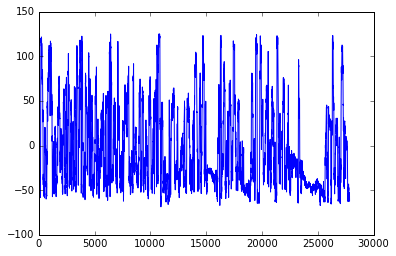

In [71]:
plt.plot(y[:,1])

In [85]:
X_test_temp.shape

(13910, 10, 46)

In [65]:
y_test_bs.shape

(10, 1391, 2)

In [144]:
print(np.mean(mean_R2_wf),np.std(mean_R2_wf)/np.sqrt(10))
print(np.mean(mean_R2_wc),np.std(mean_R2_wc)/np.sqrt(10))
print(np.mean(mean_R2_xgb),np.std(mean_R2_xgb)/np.sqrt(10))
print(np.mean(mean_R2_dnn),np.std(mean_R2_dnn)/np.sqrt(10))
print(np.mean(mean_R2_rnn),np.std(mean_R2_rnn)/np.sqrt(10))
print(np.mean(mean_R2_gru),np.std(mean_R2_gru)/np.sqrt(10))
print(np.mean(mean_R2_lstm),np.std(mean_R2_lstm)/np.sqrt(10))

(0.13268526188940383, 0.014911456174714371)
(-2222.4738895592859, 428.88764069975304)
(0.46733770271594743, 0.01912950875194112)
(0.52985305647275316, 0.022774560567318518)
(0.47961766118767335, 0.01150047013618123)
(0.60184600733658422, 0.022267109306579925)
(0.50690382415669921, 0.024701662216459985)


In [145]:
# idx=np.concatenate((np.arange(0,8),np.arange(10,10)))
mean_R2_wc

array([-3380.56885043,  -383.0745233 , -3181.54890997,  -163.14967846,
       -3713.21392569,  -763.48685699, -1747.74096771, -1735.59315108,
       -3678.15332189, -3478.20871007])

In [139]:
np.mean(mean_R2_rnn)

0.48838448251927224

In [112]:
save_folder='/home/jglaser2/Data/Decoding_Results/'
with open(save_folder+'hc_results_100spks.pickle','wb') as f:
    pickle.dump([mean_R2_wf,mean_R2_wc,mean_R2_xgb,mean_R2_dnn,mean_R2_rnn,mean_R2_gru,mean_R2_lstm],f)